## IMPORT RELEVANT LIBRARIES

In [33]:
import re
import os
import urllib

import hvplot.pandas
import pandas as pd
import numpy as np
import requests

from datetime import datetime
import datetime as dt
import matplotlib.pyplot as plt
from meteostat import Point, Daily, Monthly, Stations

# Import API key
from api_keys import geoapify_key


# Turn off warning messages
import warnings
warnings.filterwarnings("ignore")

## DATA PREPARATION


### Preparing and cleaning up of airport punctuality data

In [2]:
# rename all file names by replacing whitespaces with underscores to reduce memory load
folder = 'resources' 

for dirpath, dirnames, filenames in os.walk(folder):
    for filename in filenames:
        new_filename = filename.replace(" ","_")
        os.rename(os.path.join(dirpath, filename), os.path.join(dirpath, new_filename))

In [3]:
# Load the airport CSV files
airport_list = ['Belfast International Airport', 'Cardiff Airport', 'Glasgow Airport', 'Heathrow Airport']

# Define folders by year that hold the files
folder_2019 = "resources/2019_airport_punctuality_files"
folder_2018 = "resources/2018_airport_punctuality_files"

In [4]:
# Function to loop through  2018 directory and create dataframes from each csv file
def airport_punctuality(folder):
    airport_punctuality_df_list = []
    
#     Use a loop to run through the csv folders and dynamically extract relevant columns
    for file_name in os.listdir(folder):
        punctuality_data = pd.read_csv(f"{folder}/{file_name}")
        rename_cols = {
            "reporting_period": "Yr/Mth", 
            "reporting_airport": "Airport",
            "number_flights_cancelled" : "Cancelled Flights",
            "flights_0_to_15_minutes_late_percent": "(0-15) mins Late %", 
            "flights_between_16_and_30_minutes_late_percent": "(16-30) mins Late %", 
            "flights_between_31_and_60_minutes_late_percent": "(31-60) mins Late %", 
            "flights_between_61_and_120_minutes_late_percent": "(61-120) mins Late %", 
            "flights_between_121_and_180_minutes_late_percent": "(121-180) mins Late %", 
            "flights_between_181_and_360_minutes_late_percent": "(181-360) mins Late %", 
            "flights_more_than_360_minutes_late_percent": "360+ mins Late %",
            "flights_cancelled_percent": "Flights Cancelled %",
            "average_delay_mins": "Average mins delay",
        }
        punctuality_data = punctuality_data.rename(columns=rename_cols)[[*rename_cols.values()]]

        airport_punctuality_df_list.append(punctuality_data)
    
#     Join all the months into one dataframe using concat
    full_airport_data_df = pd.concat(airport_punctuality_df_list)
    return full_airport_data_df

In [5]:
# concat 2018 2019 dataframes
airport_punctuality_data = pd.concat([airport_punctuality(folder_2018), airport_punctuality(folder_2019)])

In [6]:
# Select only  the 4 relevant airports
airport_punctuality_data = airport_punctuality_data.loc[(airport_punctuality_data["Airport"] == "BELFAST INTERNATIONAL") | (airport_punctuality_data["Airport"] == "CARDIFF WALES") | (airport_punctuality_data["Airport"] == "GLASGOW") | (airport_punctuality_data["Airport"] == "HEATHROW")]

In [7]:
# checking the top part of the df
airport_punctuality_data.head()

,Yr/Mth,Airport,Cancelled Flights,(0-15) mins Late %,(16-30) mins Late %,(31-60) mins Late %,(61-120) mins Late %,(121-180) mins Late %,(181-360) mins Late %,360+ mins Late %,Flights Cancelled %,Average mins delay
103,201801,BELFAST INTERNATIONAL,0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
104,201801,BELFAST INTERNATIONAL,0,20.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
105,201801,BELFAST INTERNATIONAL,0,27.777778,5.555556,27.777778,0.0,0.0,0.0,0.0,0.0,15.666667
106,201801,BELFAST INTERNATIONAL,0,44.444444,22.222222,16.666667,0.0,0.0,0.0,0.0,0.0,13.777778
107,201801,BELFAST INTERNATIONAL,0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000


In [8]:
# checking for the bottom part of the df
airport_punctuality_data.tail()

,Yr/Mth,Airport,Cancelled Flights,(0-15) mins Late %,(16-30) mins Late %,(31-60) mins Late %,(61-120) mins Late %,(121-180) mins Late %,(181-360) mins Late %,360+ mins Late %,Flights Cancelled %,Average mins delay
2124,201912,HEATHROW,2,36.756757,14.054054,6.486486,2.162162,0.27027,0.27027,0.0,0.540541,11.301630
2125,201912,HEATHROW,1,40.375587,18.075117,8.920188,0.704225,0.00000,0.00000,0.0,0.234742,10.837647
2126,201912,HEATHROW,0,43.396226,20.754717,4.716981,2.830189,0.00000,0.00000,0.0,0.000000,11.235849
2127,201912,HEATHROW,0,37.423313,10.122699,6.134969,1.840491,0.00000,0.00000,0.0,0.000000,8.592025
2128,201912,HEATHROW,0,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.0,0.000000,0.000000


#### Preparing the primary weather data using nearest weather stations to relevant airports

In [9]:
# Load secondary weather txt files and convert to dataframe
target_airports = ["BELFAST INTERNATIONAL", "CARDIFF WALES", "GLASGOW", "HEATHROW"]

belfast_airport_armagh = "https://www.metoffice.gov.uk/pub/data/weather/uk/climate/stationdata/armaghdata.txt"
cardiff_airport_bute_park = "https://www.metoffice.gov.uk/pub/data/weather/uk/climate/stationdata/cardiffdata.txt"
glasgow_airport_paisley = "https://www.metoffice.gov.uk/pub/data/weather/uk/climate/stationdata/paisleydata.txt"
heathrow_airport_heathrow = "https://www.metoffice.gov.uk/pub/data/weather/uk/climate/stationdata/heathrowdata.txt"

airport_weather_stations = [belfast_airport_armagh, cardiff_airport_bute_park, glasgow_airport_paisley, heathrow_airport_heathrow]
airport_weather1 = []
for index, weather_station in enumerate(airport_weather_stations):
    airport_file = urllib.request.urlopen(weather_station)
    lines, year, month, temp_max, temp_min, af_days, rain_mm, sun_hours = [], [], [], [], [], [], [] , []
    
    for line in airport_file:
        lines.append(line.decode("utf-8"))
    lines = lines[7:]
    for line in lines:
        line = line.split()
        year.append(line[0])
        [month.append(str(0)+line[1]) if len(line[1])==1 else month.append(line[1])]
        temp_max.append(line[2])
        temp_min.append(line[3])
        af_days.append(line[4])
        rain_mm.append(line[5])
        sun_hours.append(line[6])

    weather_station_df = pd.DataFrame({"Year": year, "Month": month, "Max Temp C": temp_max, 
                                       "Min Temp C": temp_min, "Af days": af_days, "Rain mm": rain_mm, 
                                       "Sun Hrs": sun_hours})

    weather_station_df = weather_station_df.loc[(weather_station_df["Year"] >= "2018") 
                                                & (weather_station_df["Year"] <= "2019")]
    weather_station_df.insert(0, "Yr/Mth", weather_station_df["Year"]+weather_station_df["Month"])
    weather_station_df.insert(1, "Airport", target_airports[index])
    
    airport_weather1.append(weather_station_df)
    
airport_weather1 = pd.concat(airport_weather1)
airport_weather1 = airport_weather1.drop(["Year", "Month"], axis=1)
airport_weather1.head()

,Yr/Mth,Airport,Max Temp C,Min Temp C,Af days,Rain mm,Sun Hrs
1980,201801,BELFAST INTERNATIONAL,7.2,1.8,6,127.1,51.1
1981,201802,BELFAST INTERNATIONAL,7.1,0.2,11,61.6,96.6
1982,201803,BELFAST INTERNATIONAL,8.2,1.4,9,66.3,79.4
1983,201804,BELFAST INTERNATIONAL,12.8,5.0,2,75.6,129.2
1984,201805,BELFAST INTERNATIONAL,17.9,7.9,0,32.8,202.5


In [10]:
clean_values = lambda val: re.sub('[@#$*-]+', '', val)
airport_weather1["Max Temp C"] = airport_weather1["Max Temp C"].apply(clean_values)
airport_weather1["Min Temp C"] = airport_weather1["Min Temp C"].apply(clean_values)
airport_weather1["Af days"] = airport_weather1["Af days"].apply(clean_values)
airport_weather1["Rain mm"] = airport_weather1["Rain mm"].apply(clean_values)
airport_weather1["Sun Hrs"] = airport_weather1["Sun Hrs"].apply(clean_values)

#     Fill 'Sun Hrs' with 0 if they are '---'
# airport_weather1["Sun Hrs"] = airport_weather1["Sun Hrs"].apply(lambda x: x.strip()).replace('', np.nan)

# df[['Courses','Duration']].apply(lambda x: x.str.strip()).replace('', np.nan)

In [11]:
airport_weather1.head()

,Yr/Mth,Airport,Max Temp C,Min Temp C,Af days,Rain mm,Sun Hrs
1980,201801,BELFAST INTERNATIONAL,7.2,1.8,6,127.1,51.1
1981,201802,BELFAST INTERNATIONAL,7.1,0.2,11,61.6,96.6
1982,201803,BELFAST INTERNATIONAL,8.2,1.4,9,66.3,79.4
1983,201804,BELFAST INTERNATIONAL,12.8,5.0,2,75.6,129.2
1984,201805,BELFAST INTERNATIONAL,17.9,7.9,0,32.8,202.5


#### Getting secondary weather data from Meteostat.net using GEOAPIFY to grab coordinates

In [12]:
# Function to get Airport longitudes and latitudes
def airport_coord(airports):
    lat_lon = []
    for airport in airports:
        base_url = "https://api.geoapify.com/v1/geocode/search"
        params = {
            "text": airport,
            "apiKey": geoapify_key
        }
        response = requests.get(base_url, params=params).json()

        # Extract lat/lon and append
        lat = response["features"][0]["geometry"]["coordinates"][1]
        lon = response["features"][0]["geometry"]["coordinates"][0]
        lat_lon.append([lat, lon, airport])
        
    return lat_lon

In [13]:
# getting secondary weather data 

# Set time period
def fetch_weather2(coords):
    weather_data_list = []
    for coord in coords:
        start = datetime(2018, 1, 1)
        end = datetime(2019, 12, 31)

        # nearest weather station
        stations = Stations()
        stations = stations.nearby(coord[0], coord[1])
        station = stations.fetch(1)
        station = pd.DataFrame(station)
        
        # Get station WMO id
        wmo = station.iloc[0,3]

        # Get Monthly data
        data = Monthly(wmo, start, end)
        data = data.fetch()
        data.reset_index(inplace = True)
 
        data.insert(0, "Month", data['time'].dt.month.astype(str))
        data.insert(0, "Year", data['time'].dt.year.astype(str))        
    
        # Create a Yr/Mth column by concatenating year and month adding leading zero to single month digit
        mth_len = lambda x: x.Year+str(x.Month) if len(str(x.Month)) > 1 else x.Year+"0"+str(x.Month)
        data.insert(0, "Yr/Mth", "")
        data["Yr/Mth"] = data.apply(mth_len, axis=1)
        
        data.insert(1, "Airport", coord[2])
        
        weather_data_list.append(data)        
        
    return weather_data_list
airport_weather2 = pd.concat(fetch_weather2(airport_coord(target_airports)))

# select useful columns  for merge
airport_weather2 = airport_weather2[["Yr/Mth", "Airport" ,"tavg", "wspd"]]
airport_weather2 = airport_weather2.rename(columns = {"tavg": "Temp Avg", "wspd": "WSPD"})

In [14]:
# Show the head
airport_weather2.head()

,Yr/Mth,Airport,Temp Avg,WSPD
0,201801,BELFAST INTERNATIONAL,4.2,18.7
1,201802,BELFAST INTERNATIONAL,3.0,16.7
2,201803,BELFAST INTERNATIONAL,4.0,NaN
3,201804,BELFAST INTERNATIONAL,8.1,NaN
4,201805,BELFAST INTERNATIONAL,12.3,14.0


In [15]:
airport_punctuality_data.reset_index().set_index("Yr/Mth", inplace=True)

In [16]:
# Group airport punctuality data by year/month and airport
airport_punctuality_data = airport_punctuality_data.groupby(["Yr/Mth", "Airport"]).aggregate({
    "(0-15) mins Late %": "mean",
    "(16-30) mins Late %": "mean",
    "(31-60) mins Late %": "mean", 
    "(61-120) mins Late %": "mean",
    "(121-180) mins Late %": "mean",
    "(181-360) mins Late %": "mean",
    "360+ mins Late %": "mean",
    "Flights Cancelled %": "mean",
    "Average mins delay": "mean"    
    })
airport_punctuality_data.reset_index(inplace=True)
airport_punctuality_data.head(10)

,Yr/Mth,Airport,(0-15) mins Late %,(16-30) mins Late %,(31-60) mins Late %,(61-120) mins Late %,(121-180) mins Late %,(181-360) mins Late %,360+ mins Late %,Flights Cancelled %,Average mins delay
0,201801,BELFAST INTERNATIONAL,32.034984,9.603243,7.174043,2.417528,1.096066,0.216237,0.006777,0.000000,11.139891
1,201801,CARDIFF WALES,20.124438,7.362583,7.664679,2.683412,0.660578,0.628191,0.000000,0.751386,10.929945
2,201801,GLASGOW,21.075249,8.465888,6.905483,3.928779,0.752503,0.300339,0.025117,2.045249,11.401152
3,201801,HEATHROW,27.932613,10.229942,7.687583,2.990767,0.989967,0.467223,0.214001,1.081863,13.817666
4,201802,BELFAST INTERNATIONAL,30.992039,9.301437,4.844294,1.687401,0.583784,0.202439,0.091912,0.090269,9.329563
5,201802,CARDIFF WALES,27.829256,7.255356,4.430919,0.877058,0.080769,0.057692,0.000000,0.498022,6.364089
6,201802,GLASGOW,24.549152,8.200257,4.745592,1.656615,0.903715,0.846131,0.044051,2.975849,10.423810
7,201802,HEATHROW,29.409211,8.633664,5.670170,2.534016,0.721949,0.458558,0.123129,0.779008,11.334584
8,201803,BELFAST INTERNATIONAL,36.577261,8.884868,3.618047,2.520563,2.200861,0.452588,0.105617,0.734901,12.742781
9,201803,CARDIFF WALES,18.745190,7.915412,7.964065,3.187520,3.790023,6.068602,0.762962,8.288995,37.400737


#### Merging all 3 dataframes

In [17]:
# Finally merging all the data frames 
final_data = pd.merge(airport_weather1, airport_weather2, how="outer")
final_data['Yr/Mth'] = final_data['Yr/Mth'].astype(int)

final_data = pd.merge(airport_punctuality_data, final_data)

# ensure that all columns are double data types
final_data['(0-15) mins Late %'] = final_data['(0-15) mins Late %'].astype(float)
final_data['(16-30) mins Late %'] = final_data['(16-30) mins Late %'].astype(float)
final_data['(31-60) mins Late %'] = final_data['(31-60) mins Late %'].astype(float)
final_data['(61-120) mins Late %'] = final_data['(61-120) mins Late %'].astype(float)
final_data['(121-180) mins Late %'] = final_data['(121-180) mins Late %'].astype(float)
final_data['(181-360) mins Late %'] = final_data['(181-360) mins Late %'].astype(float)
final_data['360+ mins Late %'] = final_data['360+ mins Late %'].astype(float)
final_data['Flights Cancelled %'] = final_data['Flights Cancelled %'].astype(float)
final_data['Average mins delay'] = final_data['Average mins delay'].astype(float)
final_data['Max Temp C'] = final_data['Max Temp C'].astype(float)
final_data['Af days'] = final_data['Af days'].astype(float)
final_data['Rain mm'] = final_data['Rain mm'].astype(float)
# final_data['Sun Hrs'] = final_data['Sun Hrs'].astype(float)
final_data['Temp Avg'] = final_data['Temp Avg'].astype(float)
final_data['WSPD'] = final_data['WSPD'].astype(float)

In [18]:
final_data.head(50)

,Yr/Mth,Airport,(0-15) mins Late %,(16-30) mins Late %,(31-60) mins Late %,(61-120) mins Late %,(121-180) mins Late %,(181-360) mins Late %,360+ mins Late %,Flights Cancelled %,Average mins delay,Max Temp C,Min Temp C,Af days,Rain mm,Sun Hrs,Temp Avg,WSPD
0,201801,BELFAST INTERNATIONAL,32.034984,9.603243,7.174043,2.417528,1.096066,0.216237,0.006777,0.000000,11.139891,7.2,1.8,6.0,127.1,51.1,4.2,18.7
1,201801,CARDIFF WALES,20.124438,7.362583,7.664679,2.683412,0.660578,0.628191,0.000000,0.751386,10.929945,9.4,2.7,9.0,153.2,,6.2,NaN
2,201801,GLASGOW,21.075249,8.465888,6.905483,3.928779,0.752503,0.300339,0.025117,2.045249,11.401152,6.0,1.2,10.0,175.1,39.7,3.6,NaN
3,201801,HEATHROW,27.932613,10.229942,7.687583,2.990767,0.989967,0.467223,0.214001,1.081863,13.817666,9.7,3.8,1.0,58.0,46.5,6.7,18.7
4,201802,BELFAST INTERNATIONAL,30.992039,9.301437,4.844294,1.687401,0.583784,0.202439,0.091912,0.090269,9.329563,7.1,0.2,11.0,61.6,96.6,3.0,16.7
5,201802,CARDIFF WALES,27.829256,7.255356,4.430919,0.877058,0.080769,0.057692,0.000000,0.498022,6.364089,7.5,0.8,14.0,50.0,,3.8,19.4
6,201802,GLASGOW,24.549152,8.200257,4.745592,1.656615,0.903715,0.846131,0.044051,2.975849,10.423810,6.4,0.1,12.0,67.6,94.5,3.0,14.7
7,201802,HEATHROW,29.409211,8.633664,5.670170,2.534016,0.721949,0.458558,0.123129,0.779008,11.334584,6.7,0.6,12.0,29.0,92.0,3.6,14.7
8,201803,BELFAST INTERNATIONAL,36.577261,8.884868,3.618047,2.520563,2.200861,0.452588,0.105617,0.734901,12.742781,8.2,1.4,9.0,66.3,79.4,4.0,NaN
9,201803,CARDIFF WALES,18.745190,7.915412,7.964065,3.187520,3.790023,6.068602,0.762962,8.288995,37.400737,9.1,2.5,6.0,163.4,,NaN,NaN


## ANALYSIS

In [19]:
# Airport names
# four_airports = ["BELFAST INTERNATIONAL", "CARDIFF WALES", "GLASGOW", "HEATHROW"]


# grouping final data into seasons.
final_by_season = final_data[(final_data["Yr/Mth"] == 201812) | (final_data["Yr/Mth"] == 201901)
                             | (final_data["Yr/Mth"] == 201902) | (final_data["Yr/Mth"] == 201906)
                             | (final_data["Yr/Mth"] == 201907) | (final_data["Yr/Mth"] == 201908)]

# create a lambda function to select winter and summer months apply to form a new column (Season)
season = lambda x: "Winter" if (x["Yr/Mth"] == 201812 or x["Yr/Mth"] == 201901 or x["Yr/Mth"] == 201902) else "Summer"
final_by_season["Season"] = final_data.apply(season, axis=1)

# rearrange columns moving seasons in first position
move_season_to_first = ["Season", "Yr/Mth", "Airport","(0-15) mins Late %", "(16-30) mins Late %", 
                        "(31-60) mins Late %", "(61-120) mins Late %", "(121-180) mins Late %", 
                        "(181-360) mins Late %", "360+ mins Late %", "Flights Cancelled %", 
                        "Average mins delay", "Max Temp C", "Min Temp C", "Af days", "Rain mm", 
                        "Sun Hrs", "Temp Avg", "WSPD"]

final_by_season = final_by_season[move_season_to_first]

In [20]:
final_by_season.head()

,Season,Yr/Mth,Airport,(0-15) mins Late %,(16-30) mins Late %,(31-60) mins Late %,(61-120) mins Late %,(121-180) mins Late %,(181-360) mins Late %,360+ mins Late %,Flights Cancelled %,Average mins delay,Max Temp C,Min Temp C,Af days,Rain mm,Sun Hrs,Temp Avg,WSPD
44,Winter,201812,BELFAST INTERNATIONAL,25.028433,5.746644,7.201370,2.029086,0.233704,0.102166,0.000000,0.088540,7.819830,9.0,4.8,2.0,85.7,23.5,7.0,16.9
45,Winter,201812,CARDIFF WALES,28.806564,5.571479,7.025531,3.076889,0.299348,0.094162,0.052966,2.051577,9.169403,10.6,5.5,1.0,196.4,,8.5,20.4
46,Winter,201812,GLASGOW,22.555842,7.151600,7.106858,2.376586,1.211333,0.875315,0.020610,1.498128,12.210287,8.0,2.8,8.0,98.2,31.8,5.5,14.0
47,Winter,201812,HEATHROW,32.736985,13.381447,9.836655,4.642881,1.582959,0.639554,0.159512,0.516041,18.320112,10.7,5.2,2.0,60.6,40.3,7.9,15.8
48,Winter,201901,BELFAST INTERNATIONAL,26.965699,6.501638,4.482411,1.353257,0.479526,0.376367,0.065359,0.013548,8.546754,7.9,3.0,7.0,22.2,39.4,5.3,13.8


In [21]:
#  dataframe group by seasons and all airports
final_by_season_airport = final_by_season.groupby(["Season", "Airport"]).mean()
final_by_season_airport

Yr/Mth  (0-15) mins Late %  \
Season Airport                                                    
Summer BELFAST INTERNATIONAL  201907.000000           23.540552   
       CARDIFF WALES          201907.000000           30.222197   
       GLASGOW                201907.000000           25.024944   
       HEATHROW               201907.000000           31.631558   
Winter BELFAST INTERNATIONAL  201871.666667           26.891004   
       CARDIFF WALES          201871.666667           28.600662   
       GLASGOW                201871.666667           21.038615   
       HEATHROW               201871.666667           30.047034   

                              (16-30) mins Late %  (31-60) mins Late %  \
Season Airport                                                           
Summer BELFAST INTERNATIONAL             9.241796             5.336633   
       CARDIFF WALES                     9.559826             8.515077   
       GLASGOW                          10.180133             8.398669   
       HEATHROW                         12.151629             8.928580   
Winter BELFAST INTERNATIONAL             5.621962             5.068272   
       CARDIFF WALES                     5.240405             5.856215   
       GLASGOW                           6.301965             4.979318   
       HEATHROW                         10.106652             7.032245   

                              (61-120) mins Late %  (121-180) mins Late %  \
Season Airport                                                              
Summer BELFAST INTERNATIONAL              3.672369               0.714863   
       CARDIFF WALES                      3.997247               0.965409   
       GLASGOW                            3.537616               0.913874   
       HEATHROW                           4.229558               1.117047   
Winter BELFAST INTERNATIONAL              1.524113               0.290055   
       CARDIFF WALES                      2.393657               0.292611   
       GLASGOW                            2.167372               0.748428   
       HEATHROW                           3.658753               0.955385   

                              (181-360) mins Late %  360+ mins Late %  \
Season Airport                                                          
Summer BELFAST INTERNATIONAL               0.676534          0.020445   
       CARDIFF WALES                       0.480985          0.395016   
       GLASGOW                             0.453841          0.136419   
       HEATHROW                            0.573345          0.176457   
Winter BELFAST INTERNATIONAL               0.194644          0.023107   
       CARDIFF WALES                       0.140800          0.017655   
       GLASGOW                             0.399712          0.028309   
       HEATHROW                            0.553443          0.223430   

                              Flights Cancelled %  Average mins delay  \
Season Airport                                                          
Summer BELFAST INTERNATIONAL             0.016567           11.584894   
       CARDIFF WALES                     0.257913           16.496654   
       GLASGOW                           0.521851           14.115883   
       HEATHROW                          0.766039           16.661785   
Winter BELFAST INTERNATIONAL             0.050520            7.331189   
       CARDIFF WALES                     1.373913            7.947327   
       GLASGOW                           1.113301            9.148923   
       HEATHROW                          0.801462           14.380687   

                              Max Temp C   Af days     Rain mm   Temp Avg  \
Season Airport                                                              
Summer BELFAST INTERNATIONAL   19.666667  0.000000   95.266667  15.200000   
       CARDIFF WALES           21.600000  0.000000  101.866667  16.366667   
       GLASGOW                 20.000000  0.000000  119.866667  15.133333   
       

### Plotting for All Airports, Summer VS Winter  by % Cancellations

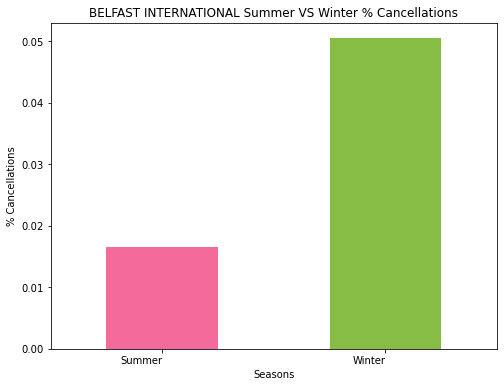

In [22]:
# dataframe for belfast international
barplot_color1 = ['#f46a9b', '#87bc45']
barplot_color2 = ['#e14b31','#ffb400']
final_by_season_belfast = final_by_season[(final_by_season["Airport"] == "BELFAST INTERNATIONAL")]
final_by_season_belfast = final_by_season_belfast.groupby("Season")["Flights Cancelled %"].mean()

# Belfast Airport Plot
belfast_plot = final_by_season_belfast.plot(kind='bar', color=barplot_color1, figsize=(8,6), title= "BELFAST INTERNATIONAL Summer VS Winter % Cancellations",
 xlabel="Seasons", ylabel="% Cancellations")

xticklabels = final_by_season_belfast.index
belfast_plot.set_xticklabels(xticklabels, rotation=0, rotation_mode="anchor", ha="right", wrap=True)
plt.show()

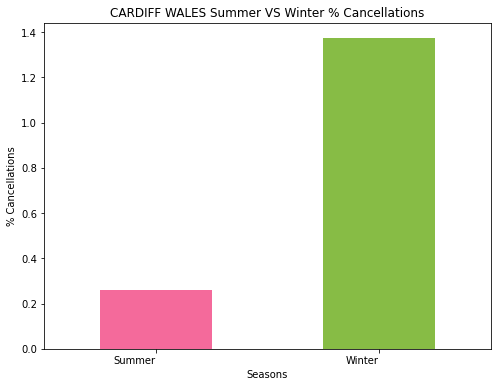

In [23]:
# dataframe for cardiff wales
final_by_season_cardiff = final_by_season[(final_by_season["Airport"] == "CARDIFF WALES")]
final_by_season_cardiff = final_by_season_cardiff.groupby("Season")["Flights Cancelled %"].mean()

# Cardiff Airport Plot
cardiff_plot = final_by_season_cardiff.plot(kind='bar', color=barplot_color1, figsize=(8,6), title= "CARDIFF WALES Summer VS Winter % Cancellations",
 xlabel="Seasons", ylabel="% Cancellations")

xticklabels = final_by_season_belfast.index
cardiff_plot.set_xticklabels(xticklabels, rotation=0, rotation_mode="anchor", ha="right", wrap=True)
plt.show()

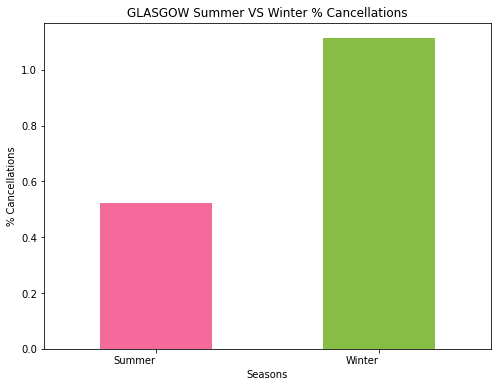

In [24]:
# dataframe for glasgow
final_by_season_glasgow = final_by_season[(final_by_season["Airport"] == "GLASGOW")]
final_by_season_glasgow = final_by_season_glasgow.groupby("Season")["Flights Cancelled %"].mean()

# glasgow Airport Plot
glasgow_plot = final_by_season_glasgow.plot(kind='bar', color=barplot_color1, figsize=(8,6), title= "GLASGOW Summer VS Winter % Cancellations",
 xlabel="Seasons", ylabel="% Cancellations")

xticklabels = final_by_season_glasgow.index
glasgow_plot.set_xticklabels(xticklabels, rotation=0, rotation_mode="anchor", ha="right", wrap=True)
plt.show()

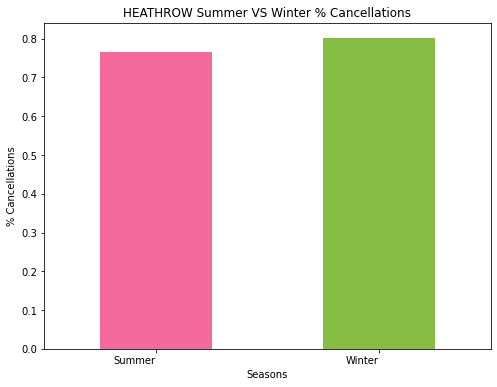

In [25]:
# dataframe for heathrow
final_by_season_heathrow = final_by_season[(final_by_season["Airport"] == "HEATHROW")]
final_by_season_heathrow = final_by_season_heathrow.groupby("Season")["Flights Cancelled %"].mean()

# Heathrow Airport Plot
heathrow_plot = final_by_season_heathrow.plot(kind='bar', color=barplot_color1, figsize=(8,6), title= "HEATHROW Summer VS Winter % Cancellations",
 xlabel="Seasons", ylabel="% Cancellations")

xticklabels = final_by_season_heathrow.index
heathrow_plot.set_xticklabels(xticklabels, rotation= 0, rotation_mode="anchor", ha="right", wrap=True)
plt.show()

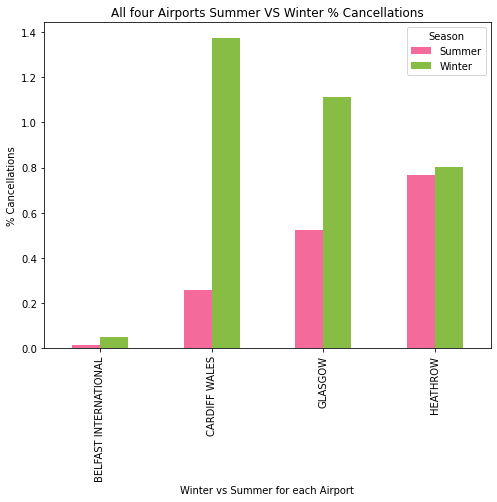

In [26]:
#  Plotting for all 4 airports against % Cancellation
final_by_season_cardiff = pd.pivot_table(
    data = final_by_season,
    index="Airport",
    columns = "Season",
    values='Flights Cancelled %'
)
cardiff_plot = final_by_season_cardiff.plot(kind='bar', color=barplot_color1, figsize=(8,6), title=f"All four Airports Summer VS Winter % Cancellations",
 xlabel="Winter vs Summer for each Airport", ylabel="% Cancellations")

plt.show()

### Plotting for All Airports, Summer VS Winter  by % Late (6 hours or more)

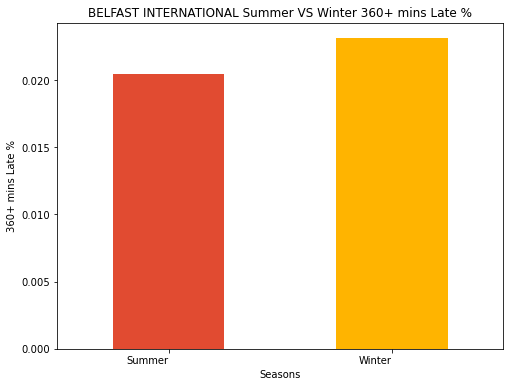

In [27]:
# dataframe for belfast international
final_by_season_belfast = final_by_season[(final_by_season["Airport"] == "BELFAST INTERNATIONAL")]
final_by_season_belfast = final_by_season_belfast.groupby("Season")["360+ mins Late %"].mean()

# Belfast Airport Plot
belfast_plot = final_by_season_belfast.plot(kind='bar', color=barplot_color2, figsize=(8,6), title= "BELFAST INTERNATIONAL Summer VS Winter 360+ mins Late %",
 xlabel="Seasons", ylabel="360+ mins Late %")

xticklabels = final_by_season_belfast.index
belfast_plot.set_xticklabels(xticklabels, rotation=0, rotation_mode="anchor", ha="right", wrap=True)
plt.show()

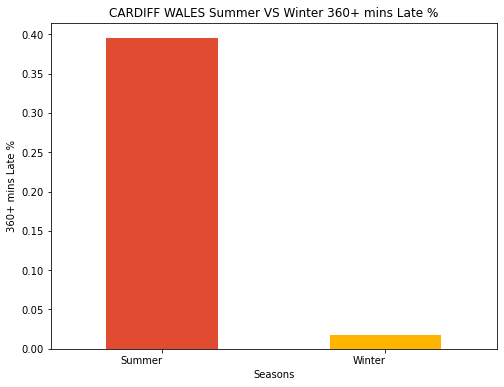

In [28]:
# dataframe for cardiff wales
final_by_season_cardiff = final_by_season[(final_by_season["Airport"] == "CARDIFF WALES")]
final_by_season_cardiff = final_by_season_cardiff.groupby("Season")["360+ mins Late %"].mean()

# Cardiff Airport Plot
cardiff_plot = final_by_season_cardiff.plot(kind='bar', color=barplot_color2, figsize=(8,6), title= "CARDIFF WALES Summer VS Winter 360+ mins Late %",
 xlabel="Seasons", ylabel="360+ mins Late %")

xticklabels = final_by_season_belfast.index
cardiff_plot.set_xticklabels(xticklabels, rotation=0, rotation_mode="anchor", ha="right", wrap=True)
plt.show()

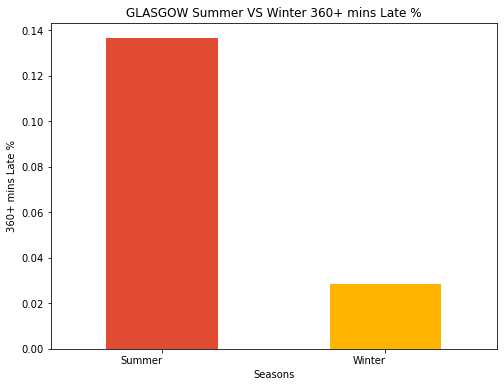

In [29]:
# dataframe for glasgow
final_by_season_glasgow = final_by_season[(final_by_season["Airport"] == "GLASGOW")]
final_by_season_glasgow = final_by_season_glasgow.groupby("Season")["360+ mins Late %"].mean()

# glasgow Airport Plot
glasgow_plot = final_by_season_glasgow.plot(kind='bar', color=barplot_color2, figsize=(8,6), title= "GLASGOW Summer VS Winter 360+ mins Late %",
 xlabel="Seasons", ylabel="360+ mins Late %")

xticklabels = final_by_season_glasgow.index
glasgow_plot.set_xticklabels(xticklabels, rotation=0, rotation_mode="anchor", ha="right", wrap=True)
plt.show()

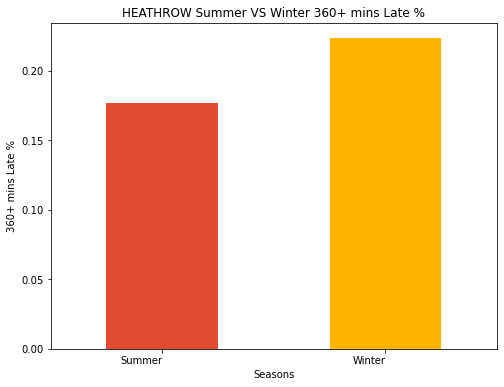

In [30]:
# dataframe for heathrow
final_by_season_heathrow = final_by_season[(final_by_season["Airport"] == "HEATHROW")]
final_by_season_heathrow = final_by_season_heathrow.groupby("Season")["360+ mins Late %"].mean()

# Heathrow Airport Plot
heathrow_plot = final_by_season_heathrow.plot(kind='bar', color=barplot_color2, figsize=(8,6), title= "HEATHROW Summer VS Winter 360+ mins Late %",
 xlabel="Seasons", ylabel="360+ mins Late %")

xticklabels = final_by_season_heathrow.index
heathrow_plot.set_xticklabels(xticklabels, rotation= 0, rotation_mode="anchor", ha="right", wrap=True)
plt.show()

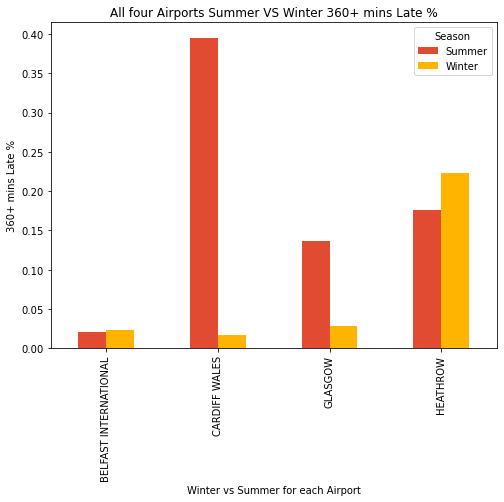

In [31]:
#  Plotting for all 4 airports against % Cancellation
final_by_season_cardiff = pd.pivot_table(
    data = final_by_season,
    index="Airport",
    columns = "Season",
    values='360+ mins Late %'
)
cardiff_plot = final_by_season_cardiff.plot(kind='bar', color=barplot_color2, figsize=(8,6), title="All four Airports Summer VS Winter 360+ mins Late %",
 xlabel="Winter vs Summer for each Airport", ylabel="360+ mins Late %")

plt.show()

In [35]:
### Show Airports on maps

In [37]:
# Function to get Airport longitudes and latitudes
all_airports = 
def airport_coord(airports):
    lat_lon = []
    
    for airport in airports:
        base_url = "https://api.geoapify.com/v1/geocode/search"
        params = {
            "text": airport,
            "apiKey": geoapify_key
        }
        response = requests.get(base_url, params=params).json()

        # Extract lat/lon and append
        lat = response["features"][0]["geometry"]["coordinates"][1]
        lon = response["features"][0]["geometry"]["coordinates"][0]
        lat_lon.append([lat, lon, airport])
        
    return lat_lon

SyntaxError: invalid syntax (1448782680.py, line 2)

In [36]:
%%capture --no-display

# Configure the map plot
map_plot_1 = city_data_df.hvplot.points(
    "Lng",
    "Lat",
    geo = True,
    tiles = "OSM",
    size = "Humidity",
    frame_width = 800,
    frame_height = 600,
    scale = 0.7,
    color = "City"
)


# Display the map
map_plot_1

NameError: name 'city_data_df' is not defined